# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install --upgrade albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
Looking in indexes: https://mirrors.aliyun.com/pypi/simple


# Download Dataset

> original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


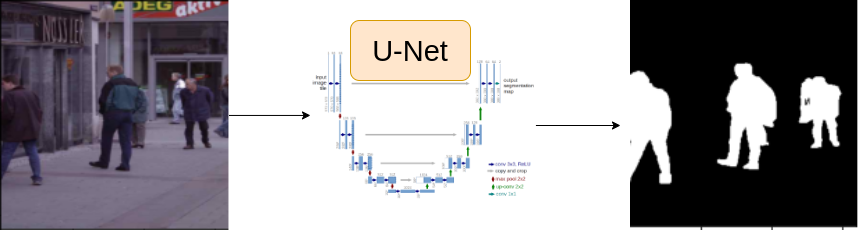

# Some Common Imports

In [3]:
import sys
sys.path.append('Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2
from torchsummary import summary as torchsumm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task 2 : Setup Configurations

In [5]:
CSV_FILE = 'Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = ''

DEVICE = 'cuda'

EPOCHS = 50
LR = 0.003

IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

SEED = 35

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
idx = 4
row = df.iloc[idx]

img_path = row.images
mask_path = row.masks

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

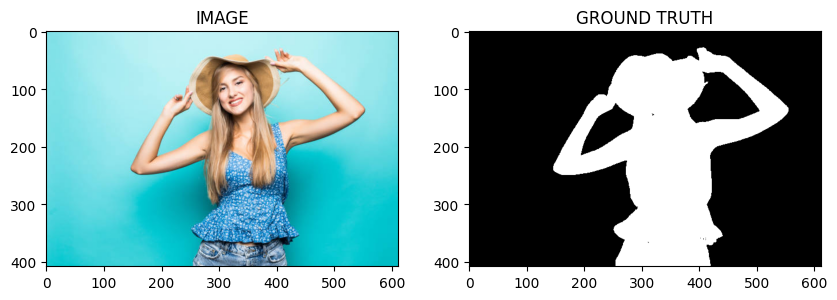

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask, cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = SEED)

# Task 3 : Augmentation Functions

> `albumentation` documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as alb

In [11]:
def get_train_augs():
    return alb.Compose([
        alb.Resize(IMG_SIZE, IMG_SIZE),
        alb.HorizontalFlip(p = 0.5),
        alb.VerticalFlip(p = 0.5)
    ], is_check_shapes=False)

def get_valid_augs():
    return alb.Compose([
        alb.Resize(IMG_SIZE, IMG_SIZE),
    ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):

    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row.images
        mask_path = row.masks

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis = -1)

        if self.augmentations:
            data = self.augmentations(image = image, mask = mask)
            image = data['image']
            mask = data['mask']

        # (hgt, wgt, chl) => (chl, hgt, wgt)

        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)

        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


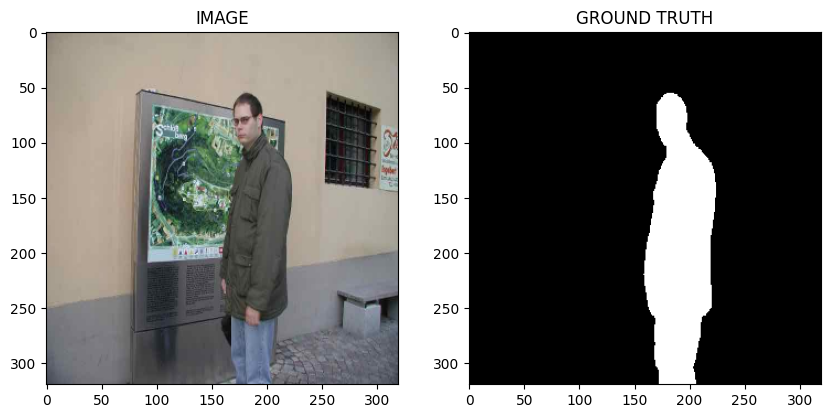

In [16]:
idx = 5

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [19]:
print(f'Total number of batches in train loader: {len(trainloader)}')
print(f'Total number of batches in valid loader: {len(validloader)}')

Total number of batches in train loader: 15
Total number of batches in valid loader: 4


In [20]:
for image, mask in trainloader:
    break

print(f'One batch image shape: {image.shape}')
print(f'One batch mask shape: {mask.shape}')

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

> `segmentation_models_pytorch` documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arch = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights= WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self,images,masks=None):
    logits = self.arch(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits,masks)
      return logits, loss1+loss2
    return logits

In [23]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arch): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
          

In [24]:
torchsumm(model, input_size=(3, 320, 320), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 160, 160]             864
          Identity-2         [-1, 32, 160, 160]               0
             Swish-3         [-1, 32, 160, 160]               0
    BatchNormAct2d-4         [-1, 32, 160, 160]              64
            Conv2d-5         [-1, 32, 160, 160]             288
          Identity-6         [-1, 32, 160, 160]               0
             Swish-7         [-1, 32, 160, 160]               0
    BatchNormAct2d-8         [-1, 32, 160, 160]              64
            Conv2d-9              [-1, 8, 1, 1]             264
            Swish-10              [-1, 8, 1, 1]               0
           Conv2d-11             [-1, 32, 1, 1]             288
          Sigmoid-12             [-1, 32, 1, 1]               0
    SqueezeExcite-13         [-1, 32, 160, 160]               0
           Conv2d-14         [-1, 16, 1

/opt/conda/lib/python3.10/site-packages/torchsummary/torchsummary.py:93: RuntimeWarning: overflow encountered in scalar add
  total_output += np.prod(summary[layer]["output_shape"])


# Task 7 : Create Train and Validation Function

In [25]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0

  for images,masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(data_loader)

In [26]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for images,masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images,masks)

      total_loss += loss.item()

  return total_loss/len(data_loader)

# Task 8 : Train Model

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [28]:
best_valid_loss = np.Inf

for epoch in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("Saved Model")
    best_valid_loss = valid_loss

  print(f"Eposch = {epoch+1} Train loss : {train_loss} Valid loss {valid_loss}")

100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56it/s]


Saved Model
Eposch = 1 Train loss : 0.7425259967645009 Valid loss 1.142074540257454


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


Saved Model
Eposch = 2 Train loss : 0.37808453738689424 Valid loss 0.5313331782817841


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.89it/s]


Saved Model
Eposch = 3 Train loss : 0.32908494273821515 Valid loss 0.3641461655497551


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.59it/s]


Saved Model
Eposch = 4 Train loss : 0.3029244065284729 Valid loss 0.3016820475459099


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.22it/s]


Saved Model
Eposch = 5 Train loss : 0.29168420533339184 Valid loss 0.2525414526462555


100%|██████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Saved Model
Eposch = 6 Train loss : 0.18954723328351974 Valid loss 0.16165847703814507


100%|██████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.62it/s]


Eposch = 7 Train loss : 0.2566248377164205 Valid loss 0.2438001148402691


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


Eposch = 8 Train loss : 0.20088838835557302 Valid loss 0.20707860589027405


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.31it/s]


Eposch = 9 Train loss : 0.19632801314194998 Valid loss 0.24935472011566162


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.11it/s]


Saved Model
Eposch = 10 Train loss : 0.20293724934260052 Valid loss 0.13466811180114746


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.70it/s]


Saved Model
Eposch = 11 Train loss : 0.15075315783421198 Valid loss 0.13199175521731377


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


Eposch = 12 Train loss : 0.1579228346546491 Valid loss 0.13795902952551842


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.87it/s]


Eposch = 13 Train loss : 0.15177066773176193 Valid loss 0.1392128150910139


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.71it/s]


Eposch = 14 Train loss : 0.14103973060846328 Valid loss 0.14055853337049484


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


Eposch = 15 Train loss : 0.13239248543977739 Valid loss 0.16366257704794407


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.57it/s]


Eposch = 16 Train loss : 0.15166778961817423 Valid loss 0.15401814505457878


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.16it/s]


Eposch = 17 Train loss : 0.17886273016532261 Valid loss 0.23821202479302883


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.95it/s]


Eposch = 18 Train loss : 0.1980121910572052 Valid loss 0.19845432043075562


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.33it/s]


Eposch = 19 Train loss : 0.20667798221111297 Valid loss 0.1652419026941061


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.97it/s]


Eposch = 20 Train loss : 0.15271815458933513 Valid loss 0.16927142068743706


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.55it/s]


Eposch = 21 Train loss : 0.1294978161652883 Valid loss 0.14086990244686604


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Eposch = 22 Train loss : 0.11502334276835123 Valid loss 0.1369345411658287


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.91it/s]


Saved Model
Eposch = 23 Train loss : 0.10273861885070801 Valid loss 0.11777740996330976


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


Eposch = 24 Train loss : 0.10032167881727219 Valid loss 0.13727585971355438


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.86it/s]


Eposch = 25 Train loss : 0.11035311420758566 Valid loss 0.1597969736903906


100%|██████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27it/s]


Eposch = 26 Train loss : 0.1350966989994049 Valid loss 0.22226613387465477


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.98it/s]


Eposch = 27 Train loss : 0.13167223036289216 Valid loss 0.17083315178751945


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


Eposch = 28 Train loss : 0.10734108785788218 Valid loss 0.169679157435894


100%|██████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Eposch = 29 Train loss : 0.1063898578286171 Valid loss 0.1928122341632843


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


Eposch = 30 Train loss : 0.11619896789391836 Valid loss 0.16194755025207996


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.01it/s]


Eposch = 31 Train loss : 0.10797794858614604 Valid loss 0.13382378220558167


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


Eposch = 32 Train loss : 0.1140508696436882 Valid loss 0.17639981396496296


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.58it/s]


Eposch = 33 Train loss : 0.10613090495268504 Valid loss 0.1583713162690401


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.48it/s]


Eposch = 34 Train loss : 0.09285420626401901 Valid loss 0.17443021573126316


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56it/s]


Eposch = 35 Train loss : 0.10960842122634253 Valid loss 0.20460889115929604


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


Eposch = 36 Train loss : 0.11988285581270854 Valid loss 0.1329863779246807


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.94it/s]


Eposch = 37 Train loss : 0.10543982088565826 Valid loss 0.14106127247214317


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


Eposch = 38 Train loss : 0.08406442105770111 Valid loss 0.15541460178792477


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.83it/s]


Eposch = 39 Train loss : 0.0805533101161321 Valid loss 0.13986948505043983


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


Eposch = 40 Train loss : 0.0706479142109553 Valid loss 0.1359854992479086


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.34it/s]


Eposch = 41 Train loss : 0.06821428909897805 Valid loss 0.131051829084754


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.10it/s]


Eposch = 42 Train loss : 0.07497618248065313 Valid loss 0.12485453858971596


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.77it/s]


Eposch = 43 Train loss : 0.07275590325395266 Valid loss 0.1455812882632017


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.16it/s]


Eposch = 44 Train loss : 0.06811982865134875 Valid loss 0.148770434781909


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


Eposch = 45 Train loss : 0.08828017512957255 Valid loss 0.1515579391270876


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.78it/s]


Eposch = 46 Train loss : 0.08948164532581965 Valid loss 0.11899134144186974


100%|██████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Saved Model
Eposch = 47 Train loss : 0.0930898090203603 Valid loss 0.11529039405286312


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.60it/s]


Eposch = 48 Train loss : 0.08303452456990877 Valid loss 0.11896332912147045


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.86it/s]


Eposch = 49 Train loss : 0.0767098106443882 Valid loss 0.11614629812538624


100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.78it/s]

Eposch = 50 Train loss : 0.07009589597582817 Valid loss 0.12797474302351475


# Task 9 : Inference

In [29]:
idx = 8

model.load_state_dict(torch.load('best_model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)

pred_mask = (pred_mask>0.5)*1.0

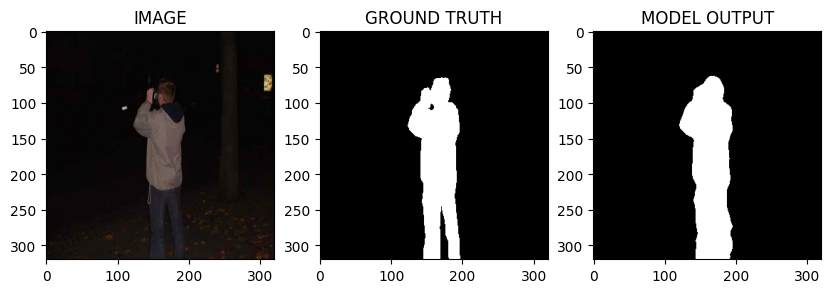

In [30]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya